In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split 
from sklearn.base import BaseEstimator, TransformerMixin
import itertools
from sklearn.metrics import mean_squared_error as mse
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit

pd.options.display.max_columns = 500

Goal:
- correctly restore the selling price for each car
- use DecisionTreeRegressor
- implement own MeanTargetEncoder class with some noise added
- select the best combination of parameters using GridSearchCV

In [2]:
data = pd.read_csv('autos.csv')

data.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner
0,Maruti 800 AC,2007,60000,70000,Petrol,Individual,Manual,First Owner
1,Maruti Wagon R LXI Minor,2007,135000,50000,Petrol,Individual,Manual,First Owner
2,Hyundai Verna 1.6 SX,2012,600000,100000,Diesel,Individual,Manual,First Owner
3,Datsun RediGO T Option,2017,250000,46000,Petrol,Individual,Manual,First Owner
4,Honda Amaze VX i-DTEC,2014,450000,141000,Diesel,Individual,Manual,Second Owner


Target: "selling price"

Metrics: MSLE

In [3]:
X = data.drop("selling_price", axis=1)
y = data["selling_price"]

### MSLE--> Therefore, let’s take the logarithm of the target

y = y.apply(np.log1p)

In [4]:
### train-test split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

Let's implement our own MeanTargetEncoder with some noise added!

New features should be calculated using the following formula:

$$
g_j(x, X) = \frac{\sum_{i=1}^{l} [f_j(x) = f_j(x_i)][y_i = +1]}{\sum_{i=1}^{l} [f_j(x) = f_j(x_i)]} + C * \epsilon
$$


Let the noise be a random variable from the normal standard distribution, that is $\epsilon \sim N(0, 1) $, а $ C = 0.006$.

Let's create our own transformer class, inheriting from the `BaseEstimator, TransformerMixin` classes from `sklearn.base`. The transformer will not modify the inplace sample passed to it, and we will calculate all the necessary statistics only from the training sample in the `fit` method.

During initialization, the transformer will accept a list of categorical attributes and a list of numeric attributes. The output will be a dataset of the same size with changed categorical features

In [5]:
### Let's divide the columns into num and categorical

object_cols = ['name', 'year', 'fuel', 'seller_type', 'transmission', 'owner']
num_cols = ['km_driven']

X.head()

,name,year,km_driven,fuel,seller_type,transmission,owner
0,Maruti 800 AC,2007,70000,Petrol,Individual,Manual,First Owner
1,Maruti Wagon R LXI Minor,2007,50000,Petrol,Individual,Manual,First Owner
2,Hyundai Verna 1.6 SX,2012,100000,Diesel,Individual,Manual,First Owner
3,Datsun RediGO T Option,2017,46000,Petrol,Individual,Manual,First Owner
4,Honda Amaze VX i-DTEC,2014,141000,Diesel,Individual,Manual,Second Owner


In [6]:
### Apply to all categorical object type columns

X[object_cols] = X[object_cols].astype(object)
X_test[object_cols] = X_test[object_cols].astype(object)
X_train[object_cols] = X_train[object_cols].astype(object)

In [7]:
np.random.seed(1)

### The function calculates the average and adds noise from the standard normal distribution

def func1(x):
    return np.sum(x) / x.size + 0.006 * np.random.normal(loc = 0.0, scale = 1.0, size =1)[0]

In [8]:
### a class that calculates average values for a target and makes them a little noisy

class MeanTargetEncoderNoise(BaseEstimator, TransformerMixin):
    
    def __init__(self, categorical, numeric):
        self.categorical = categorical
        self.numeric = numeric
    
    def fit(self, X, y):

        X['y'] = y
        
        arr = []
        
        for i in self.categorical:
            
            temp = X.groupby(i).agg({'y':[func1]}).reset_index()
            arr.append((list(temp[i]), list(temp['y']['func1'])))
            
        
        self.arr = arr

        return self
        
    def transform(self, df):
        
        arr = self.arr
        
        temp = pd.DataFrame()
        
        c = 0
        
        for i in self.categorical:
            
            setik = set(df[i].unique())
            setik.difference_update(set(arr[c][0]))

            column = df[i].replace(arr[c][0], arr[c][1]).reset_index()[i]
            column = column.replace(list(setik), 0).reset_index()[i]

            temp = pd.concat([temp, column], axis=1)
            
            c+=1        

        temp = pd.concat([df[self.numeric].reset_index(drop=True), temp], axis=1)
        
        return temp

In [9]:
np.random.seed(1)
transformer = MeanTargetEncoderNoise(categorical=object_cols, numeric=num_cols)

transformer.fit(X_train, y_train)

train = transformer.transform(X_train)
test = transformer.transform(X_test)

train

,km_driven,name,year,fuel,seller_type,transmission,owner
0,50000,13.483692,13.436559,13.093756,12.615863,13.771135,12.977730
1,70000,12.117029,11.903115,12.453832,12.615863,13.771135,12.977730
2,50000,12.310456,13.328864,12.453832,12.615863,12.639805,12.977730
3,92198,12.491443,13.042359,12.453832,13.152824,12.639805,12.463313
4,3240,12.390906,12.870886,12.453832,12.615863,12.639805,12.463313
...,...,...,...,...,...,...,...
3467,40000,11.853634,11.903115,12.453832,12.615863,12.639805,12.977730
3468,15000,13.135766,13.545966,12.453832,12.615863,12.639805,12.977730
3469,11918,13.303397,13.042359,12.453832,13.646337,12.639805,12.977730
3470,90000,13.909706,13.042359,13.093756,12.615863,12.639805,12.463313


Let's train several trees, sorting through the maximum depth of the algorithm from the list `max_depth_list`, and leave the remaining parameters as default. Let's output the best value of the hyperparameter.

Let's plot the dependence of MSLE on the test sample on the value of the hyperparameter.
Let's do the same with `min_samples_split`, `min_impurity_decrease`, `max_leaf_nodes`.

In [10]:
### Let's set up a grid of parameters

max_depth_list = [3, 5, 8, 12]
min_samples_split_list = [10, 50, 100, 500]
min_impurity_decrease_list = [0, 0.1, 0.15, 0.2]
max_leaf_nodes_list = [100, 200, 500]

In [11]:
### Let's find the best depth (with other default parameters)
np.random.seed(1)
rmse1 = []


for max_depth in max_depth_list:

    pipe = Pipeline([("custom_transformer",
                  MeanTargetEncoderNoise(categorical=object_cols, numeric=num_cols)),
                  
                  
                 ("decision_tree", 
                  DecisionTreeRegressor(max_depth=max_depth))])

    pipe.fit(X_train, y_train)
    
    preds = pipe.predict(X_test)

    rmse1.append(mse(preds, y_test, squared=True))

In [12]:
### Let's find the best minimum number of objects in a vertex (with other default parameters)

rmse2 = []
np.random.seed(1)

for min_samples_split in min_samples_split_list:

    pipe = Pipeline([("custom_transformer",
                  MeanTargetEncoderNoise(categorical=object_cols, numeric=num_cols)),
                  
                  
                 ("decision_tree", 
                  DecisionTreeRegressor(min_samples_split=min_samples_split))])

    pipe.fit(X_train, y_train)
    
    preds = pipe.predict(X_test)

    rmse2.append(mse(preds, y_test, squared=True))

In [13]:
### Let's find the best maximum number of leaves (with other default parameters)

rmse3 = []
np.random.seed(1)

for max_leaf_nodes in max_leaf_nodes_list:

    pipe = Pipeline([("custom_transformer",
                  MeanTargetEncoderNoise(categorical=object_cols, numeric=num_cols)),
                  
                  
                 ("decision_tree", 
                  DecisionTreeRegressor(max_leaf_nodes=max_leaf_nodes))])

    pipe.fit(X_train, y_train)
    
    preds = pipe.predict(X_test)

    rmse3.append(mse(preds, y_test, squared=True))

In [14]:
### Let's find the best minimal improvement of the quality criterion 
### when choosing a predicate (with other default parameters)

rmse4 = []
np.random.seed(1)

for min_impurity_decrease in min_impurity_decrease_list:

    pipe = Pipeline([("custom_transformer",
                  MeanTargetEncoderNoise(categorical=object_cols, numeric=num_cols)),
                  
                  
                 ("decision_tree", 
                  DecisionTreeRegressor(min_impurity_decrease=min_impurity_decrease))])

    pipe.fit(X_train, y_train)
    
    preds = pipe.predict(X_test)

    rmse4.append(mse(preds, y_test, squared=True))

Let us depict the quality results depending on changes in individual parameters

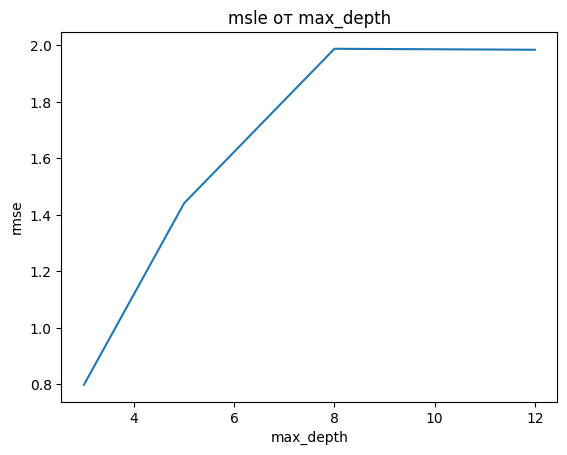

In [15]:
plt.plot(max_depth_list, rmse1)
plt.title('msle от max_depth')
plt.xlabel('max_depth')
plt.ylabel('rmse');

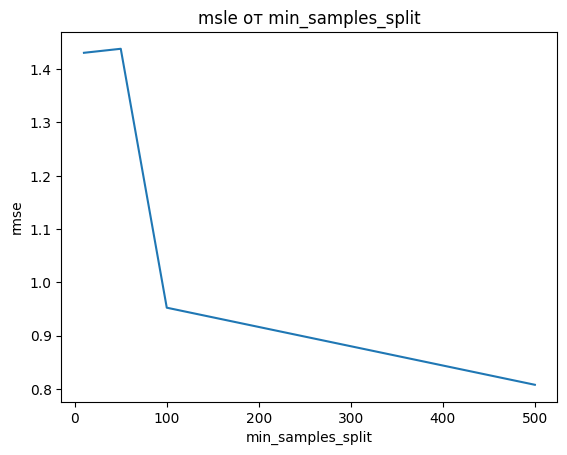

In [16]:
plt.plot(min_samples_split_list, rmse2)
plt.title('msle от min_samples_split')
plt.xlabel('min_samples_split')
plt.ylabel('rmse');

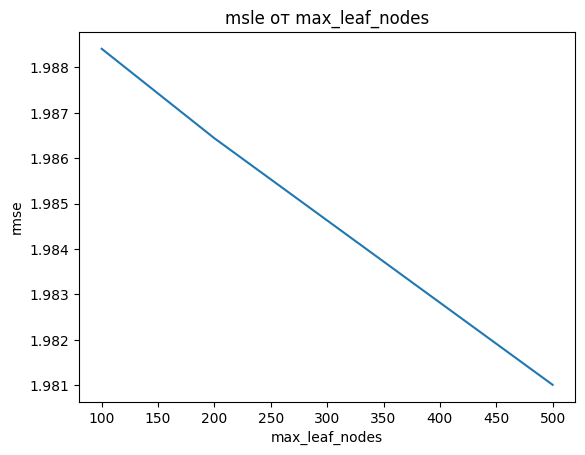

In [17]:
plt.plot(max_leaf_nodes_list, rmse3)
plt.title('msle от max_leaf_nodes')
plt.xlabel('max_leaf_nodes')
plt.ylabel('rmse');

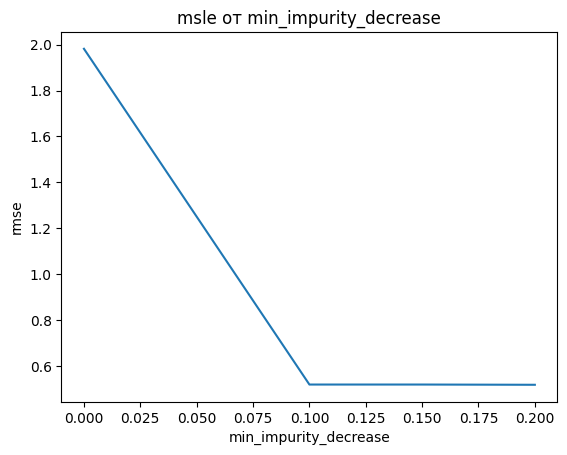

In [18]:
plt.plot(min_impurity_decrease_list, rmse4)
plt.title('msle от min_impurity_decrease')
plt.xlabel('min_impurity_decrease')
plt.ylabel('rmse');

Let's select the best combination of parameters using `GridSearchCV`. For the best combination, let's calculate MSLE on the test sample.

In [19]:
param_grid = {
    "decision_tree__max_depth": [3, 5, 8, 12],
    "decision_tree__min_samples_split": [10, 50, 100, 500],
    "decision_tree__min_impurity_decrease": [0, 0.1, 0.15, 0.2],
    "decision_tree__max_leaf_nodes": [100, 200, 500]
}
np.random.seed(1)

pipe = Pipeline([("custom_transformer",
                  MeanTargetEncoderNoise(categorical=object_cols, numeric=num_cols)),
                  
                  
                 ("decision_tree", 
                  DecisionTreeRegressor())])

search = GridSearchCV(pipe, 
                      param_grid, 
                      cv=4,
                      scoring='neg_mean_squared_error',
                      verbose=10)

search.fit(X_train, y_train)

Fitting 4 folds for each of 192 candidates, totalling 768 fits
[CV 1/4; 1/192] START decision_tree__max_depth=3, decision_tree__max_leaf_nodes=100, decision_tree__min_impurity_decrease=0, decision_tree__min_samples_split=10
[CV 1/4; 1/192] END decision_tree__max_depth=3, decision_tree__max_leaf_nodes=100, decision_tree__min_impurity_decrease=0, decision_tree__min_samples_split=10;, score=-1.050 total time=   0.7s
[CV 2/4; 1/192] START decision_tree__max_depth=3, decision_tree__max_leaf_nodes=100, decision_tree__min_impurity_decrease=0, decision_tree__min_samples_split=10
[CV 2/4; 1/192] END decision_tree__max_depth=3, decision_tree__max_leaf_nodes=100, decision_tree__min_impurity_decrease=0, decision_tree__min_samples_split=10;, score=-1.016 total time=   1.0s
[CV 3/4; 1/192] START decision_tree__max_depth=3, decision_tree__max_leaf_nodes=100, decision_tree__min_impurity_decrease=0, decision_tree__min_samples_split=10
[CV 3/4; 1/192] END decision_tree__max_depth=3, decision_tree__max_l

[CV 4/4; 6/192] END decision_tree__max_depth=3, decision_tree__max_leaf_nodes=100, decision_tree__min_impurity_decrease=0.1, decision_tree__min_samples_split=50;, score=-0.539 total time=   1.0s
[CV 1/4; 7/192] START decision_tree__max_depth=3, decision_tree__max_leaf_nodes=100, decision_tree__min_impurity_decrease=0.1, decision_tree__min_samples_split=100
[CV 1/4; 7/192] END decision_tree__max_depth=3, decision_tree__max_leaf_nodes=100, decision_tree__min_impurity_decrease=0.1, decision_tree__min_samples_split=100;, score=-0.615 total time=   1.0s
[CV 2/4; 7/192] START decision_tree__max_depth=3, decision_tree__max_leaf_nodes=100, decision_tree__min_impurity_decrease=0.1, decision_tree__min_samples_split=100
[CV 2/4; 7/192] END decision_tree__max_depth=3, decision_tree__max_leaf_nodes=100, decision_tree__min_impurity_decrease=0.1, decision_tree__min_samples_split=100;, score=-0.567 total time=   0.8s
[CV 3/4; 7/192] START decision_tree__max_depth=3, decision_tree__max_leaf_nodes=100, 

[CV 3/4; 12/192] END decision_tree__max_depth=3, decision_tree__max_leaf_nodes=100, decision_tree__min_impurity_decrease=0.15, decision_tree__min_samples_split=500;, score=-0.597 total time=   1.1s
[CV 4/4; 12/192] START decision_tree__max_depth=3, decision_tree__max_leaf_nodes=100, decision_tree__min_impurity_decrease=0.15, decision_tree__min_samples_split=500
[CV 4/4; 12/192] END decision_tree__max_depth=3, decision_tree__max_leaf_nodes=100, decision_tree__min_impurity_decrease=0.15, decision_tree__min_samples_split=500;, score=-0.539 total time=   0.7s
[CV 1/4; 13/192] START decision_tree__max_depth=3, decision_tree__max_leaf_nodes=100, decision_tree__min_impurity_decrease=0.2, decision_tree__min_samples_split=10
[CV 1/4; 13/192] END decision_tree__max_depth=3, decision_tree__max_leaf_nodes=100, decision_tree__min_impurity_decrease=0.2, decision_tree__min_samples_split=10;, score=-0.613 total time=   0.9s
[CV 2/4; 13/192] START decision_tree__max_depth=3, decision_tree__max_leaf_nod

[CV 2/4; 18/192] END decision_tree__max_depth=3, decision_tree__max_leaf_nodes=200, decision_tree__min_impurity_decrease=0, decision_tree__min_samples_split=50;, score=-1.016 total time=   0.8s
[CV 3/4; 18/192] START decision_tree__max_depth=3, decision_tree__max_leaf_nodes=200, decision_tree__min_impurity_decrease=0, decision_tree__min_samples_split=50
[CV 3/4; 18/192] END decision_tree__max_depth=3, decision_tree__max_leaf_nodes=200, decision_tree__min_impurity_decrease=0, decision_tree__min_samples_split=50;, score=-1.066 total time=   1.3s
[CV 4/4; 18/192] START decision_tree__max_depth=3, decision_tree__max_leaf_nodes=200, decision_tree__min_impurity_decrease=0, decision_tree__min_samples_split=50
[CV 4/4; 18/192] END decision_tree__max_depth=3, decision_tree__max_leaf_nodes=200, decision_tree__min_impurity_decrease=0, decision_tree__min_samples_split=50;, score=-0.889 total time=   1.1s
[CV 1/4; 19/192] START decision_tree__max_depth=3, decision_tree__max_leaf_nodes=200, decision

[CV 1/4; 24/192] END decision_tree__max_depth=3, decision_tree__max_leaf_nodes=200, decision_tree__min_impurity_decrease=0.1, decision_tree__min_samples_split=500;, score=-0.614 total time=   0.7s
[CV 2/4; 24/192] START decision_tree__max_depth=3, decision_tree__max_leaf_nodes=200, decision_tree__min_impurity_decrease=0.1, decision_tree__min_samples_split=500
[CV 2/4; 24/192] END decision_tree__max_depth=3, decision_tree__max_leaf_nodes=200, decision_tree__min_impurity_decrease=0.1, decision_tree__min_samples_split=500;, score=-0.567 total time=   0.7s
[CV 3/4; 24/192] START decision_tree__max_depth=3, decision_tree__max_leaf_nodes=200, decision_tree__min_impurity_decrease=0.1, decision_tree__min_samples_split=500
[CV 3/4; 24/192] END decision_tree__max_depth=3, decision_tree__max_leaf_nodes=200, decision_tree__min_impurity_decrease=0.1, decision_tree__min_samples_split=500;, score=-0.597 total time=   0.9s
[CV 4/4; 24/192] START decision_tree__max_depth=3, decision_tree__max_leaf_node

[CV 4/4; 29/192] END decision_tree__max_depth=3, decision_tree__max_leaf_nodes=200, decision_tree__min_impurity_decrease=0.2, decision_tree__min_samples_split=10;, score=-0.539 total time=   0.7s
[CV 1/4; 30/192] START decision_tree__max_depth=3, decision_tree__max_leaf_nodes=200, decision_tree__min_impurity_decrease=0.2, decision_tree__min_samples_split=50
[CV 1/4; 30/192] END decision_tree__max_depth=3, decision_tree__max_leaf_nodes=200, decision_tree__min_impurity_decrease=0.2, decision_tree__min_samples_split=50;, score=-0.614 total time=   0.7s
[CV 2/4; 30/192] START decision_tree__max_depth=3, decision_tree__max_leaf_nodes=200, decision_tree__min_impurity_decrease=0.2, decision_tree__min_samples_split=50
[CV 2/4; 30/192] END decision_tree__max_depth=3, decision_tree__max_leaf_nodes=200, decision_tree__min_impurity_decrease=0.2, decision_tree__min_samples_split=50;, score=-0.567 total time=   0.7s
[CV 3/4; 30/192] START decision_tree__max_depth=3, decision_tree__max_leaf_nodes=200

[CV 3/4; 35/192] END decision_tree__max_depth=3, decision_tree__max_leaf_nodes=500, decision_tree__min_impurity_decrease=0, decision_tree__min_samples_split=100;, score=-1.066 total time=   1.2s
[CV 4/4; 35/192] START decision_tree__max_depth=3, decision_tree__max_leaf_nodes=500, decision_tree__min_impurity_decrease=0, decision_tree__min_samples_split=100
[CV 4/4; 35/192] END decision_tree__max_depth=3, decision_tree__max_leaf_nodes=500, decision_tree__min_impurity_decrease=0, decision_tree__min_samples_split=100;, score=-0.889 total time=   1.1s
[CV 1/4; 36/192] START decision_tree__max_depth=3, decision_tree__max_leaf_nodes=500, decision_tree__min_impurity_decrease=0, decision_tree__min_samples_split=500
[CV 1/4; 36/192] END decision_tree__max_depth=3, decision_tree__max_leaf_nodes=500, decision_tree__min_impurity_decrease=0, decision_tree__min_samples_split=500;, score=-0.779 total time=   0.7s
[CV 2/4; 36/192] START decision_tree__max_depth=3, decision_tree__max_leaf_nodes=500, dec

[CV 2/4; 41/192] END decision_tree__max_depth=3, decision_tree__max_leaf_nodes=500, decision_tree__min_impurity_decrease=0.15, decision_tree__min_samples_split=10;, score=-0.567 total time=   1.2s
[CV 3/4; 41/192] START decision_tree__max_depth=3, decision_tree__max_leaf_nodes=500, decision_tree__min_impurity_decrease=0.15, decision_tree__min_samples_split=10
[CV 3/4; 41/192] END decision_tree__max_depth=3, decision_tree__max_leaf_nodes=500, decision_tree__min_impurity_decrease=0.15, decision_tree__min_samples_split=10;, score=-0.597 total time=   0.9s
[CV 4/4; 41/192] START decision_tree__max_depth=3, decision_tree__max_leaf_nodes=500, decision_tree__min_impurity_decrease=0.15, decision_tree__min_samples_split=10
[CV 4/4; 41/192] END decision_tree__max_depth=3, decision_tree__max_leaf_nodes=500, decision_tree__min_impurity_decrease=0.15, decision_tree__min_samples_split=10;, score=-0.539 total time=   1.2s
[CV 1/4; 42/192] START decision_tree__max_depth=3, decision_tree__max_leaf_node

[CV 1/4; 47/192] END decision_tree__max_depth=3, decision_tree__max_leaf_nodes=500, decision_tree__min_impurity_decrease=0.2, decision_tree__min_samples_split=100;, score=-0.615 total time=   1.1s
[CV 2/4; 47/192] START decision_tree__max_depth=3, decision_tree__max_leaf_nodes=500, decision_tree__min_impurity_decrease=0.2, decision_tree__min_samples_split=100
[CV 2/4; 47/192] END decision_tree__max_depth=3, decision_tree__max_leaf_nodes=500, decision_tree__min_impurity_decrease=0.2, decision_tree__min_samples_split=100;, score=-0.567 total time=   1.1s
[CV 3/4; 47/192] START decision_tree__max_depth=3, decision_tree__max_leaf_nodes=500, decision_tree__min_impurity_decrease=0.2, decision_tree__min_samples_split=100
[CV 3/4; 47/192] END decision_tree__max_depth=3, decision_tree__max_leaf_nodes=500, decision_tree__min_impurity_decrease=0.2, decision_tree__min_samples_split=100;, score=-0.597 total time=   1.1s
[CV 4/4; 47/192] START decision_tree__max_depth=3, decision_tree__max_leaf_node

[CV 4/4; 52/192] END decision_tree__max_depth=5, decision_tree__max_leaf_nodes=100, decision_tree__min_impurity_decrease=0, decision_tree__min_samples_split=500;, score=-0.653 total time=   0.7s
[CV 1/4; 53/192] START decision_tree__max_depth=5, decision_tree__max_leaf_nodes=100, decision_tree__min_impurity_decrease=0.1, decision_tree__min_samples_split=10
[CV 1/4; 53/192] END decision_tree__max_depth=5, decision_tree__max_leaf_nodes=100, decision_tree__min_impurity_decrease=0.1, decision_tree__min_samples_split=10;, score=-0.613 total time=   0.7s
[CV 2/4; 53/192] START decision_tree__max_depth=5, decision_tree__max_leaf_nodes=100, decision_tree__min_impurity_decrease=0.1, decision_tree__min_samples_split=10
[CV 2/4; 53/192] END decision_tree__max_depth=5, decision_tree__max_leaf_nodes=100, decision_tree__min_impurity_decrease=0.1, decision_tree__min_samples_split=10;, score=-0.567 total time=   0.7s
[CV 3/4; 53/192] START decision_tree__max_depth=5, decision_tree__max_leaf_nodes=100,

[CV 3/4; 58/192] END decision_tree__max_depth=5, decision_tree__max_leaf_nodes=100, decision_tree__min_impurity_decrease=0.15, decision_tree__min_samples_split=50;, score=-0.597 total time=   0.7s
[CV 4/4; 58/192] START decision_tree__max_depth=5, decision_tree__max_leaf_nodes=100, decision_tree__min_impurity_decrease=0.15, decision_tree__min_samples_split=50
[CV 4/4; 58/192] END decision_tree__max_depth=5, decision_tree__max_leaf_nodes=100, decision_tree__min_impurity_decrease=0.15, decision_tree__min_samples_split=50;, score=-0.539 total time=   0.8s
[CV 1/4; 59/192] START decision_tree__max_depth=5, decision_tree__max_leaf_nodes=100, decision_tree__min_impurity_decrease=0.15, decision_tree__min_samples_split=100
[CV 1/4; 59/192] END decision_tree__max_depth=5, decision_tree__max_leaf_nodes=100, decision_tree__min_impurity_decrease=0.15, decision_tree__min_samples_split=100;, score=-0.615 total time=   1.0s
[CV 2/4; 59/192] START decision_tree__max_depth=5, decision_tree__max_leaf_no

[CV 2/4; 64/192] END decision_tree__max_depth=5, decision_tree__max_leaf_nodes=100, decision_tree__min_impurity_decrease=0.2, decision_tree__min_samples_split=500;, score=-0.566 total time=   0.9s
[CV 3/4; 64/192] START decision_tree__max_depth=5, decision_tree__max_leaf_nodes=100, decision_tree__min_impurity_decrease=0.2, decision_tree__min_samples_split=500
[CV 3/4; 64/192] END decision_tree__max_depth=5, decision_tree__max_leaf_nodes=100, decision_tree__min_impurity_decrease=0.2, decision_tree__min_samples_split=500;, score=-0.597 total time=   0.7s
[CV 4/4; 64/192] START decision_tree__max_depth=5, decision_tree__max_leaf_nodes=100, decision_tree__min_impurity_decrease=0.2, decision_tree__min_samples_split=500
[CV 4/4; 64/192] END decision_tree__max_depth=5, decision_tree__max_leaf_nodes=100, decision_tree__min_impurity_decrease=0.2, decision_tree__min_samples_split=500;, score=-0.539 total time=   0.7s
[CV 1/4; 65/192] START decision_tree__max_depth=5, decision_tree__max_leaf_node

[CV 1/4; 70/192] END decision_tree__max_depth=5, decision_tree__max_leaf_nodes=200, decision_tree__min_impurity_decrease=0.1, decision_tree__min_samples_split=50;, score=-0.613 total time=   0.7s
[CV 2/4; 70/192] START decision_tree__max_depth=5, decision_tree__max_leaf_nodes=200, decision_tree__min_impurity_decrease=0.1, decision_tree__min_samples_split=50
[CV 2/4; 70/192] END decision_tree__max_depth=5, decision_tree__max_leaf_nodes=200, decision_tree__min_impurity_decrease=0.1, decision_tree__min_samples_split=50;, score=-0.567 total time=   0.7s
[CV 3/4; 70/192] START decision_tree__max_depth=5, decision_tree__max_leaf_nodes=200, decision_tree__min_impurity_decrease=0.1, decision_tree__min_samples_split=50
[CV 3/4; 70/192] END decision_tree__max_depth=5, decision_tree__max_leaf_nodes=200, decision_tree__min_impurity_decrease=0.1, decision_tree__min_samples_split=50;, score=-0.597 total time=   0.7s
[CV 4/4; 70/192] START decision_tree__max_depth=5, decision_tree__max_leaf_nodes=200

[CV 4/4; 75/192] END decision_tree__max_depth=5, decision_tree__max_leaf_nodes=200, decision_tree__min_impurity_decrease=0.15, decision_tree__min_samples_split=100;, score=-0.539 total time=   0.6s
[CV 1/4; 76/192] START decision_tree__max_depth=5, decision_tree__max_leaf_nodes=200, decision_tree__min_impurity_decrease=0.15, decision_tree__min_samples_split=500
[CV 1/4; 76/192] END decision_tree__max_depth=5, decision_tree__max_leaf_nodes=200, decision_tree__min_impurity_decrease=0.15, decision_tree__min_samples_split=500;, score=-0.615 total time=   0.7s
[CV 2/4; 76/192] START decision_tree__max_depth=5, decision_tree__max_leaf_nodes=200, decision_tree__min_impurity_decrease=0.15, decision_tree__min_samples_split=500
[CV 2/4; 76/192] END decision_tree__max_depth=5, decision_tree__max_leaf_nodes=200, decision_tree__min_impurity_decrease=0.15, decision_tree__min_samples_split=500;, score=-0.567 total time=   0.7s
[CV 3/4; 76/192] START decision_tree__max_depth=5, decision_tree__max_leaf

[CV 3/4; 81/192] END decision_tree__max_depth=5, decision_tree__max_leaf_nodes=500, decision_tree__min_impurity_decrease=0, decision_tree__min_samples_split=10;, score=-2.001 total time=   0.7s
[CV 4/4; 81/192] START decision_tree__max_depth=5, decision_tree__max_leaf_nodes=500, decision_tree__min_impurity_decrease=0, decision_tree__min_samples_split=10
[CV 4/4; 81/192] END decision_tree__max_depth=5, decision_tree__max_leaf_nodes=500, decision_tree__min_impurity_decrease=0, decision_tree__min_samples_split=10;, score=-1.590 total time=   0.6s
[CV 1/4; 82/192] START decision_tree__max_depth=5, decision_tree__max_leaf_nodes=500, decision_tree__min_impurity_decrease=0, decision_tree__min_samples_split=50
[CV 1/4; 82/192] END decision_tree__max_depth=5, decision_tree__max_leaf_nodes=500, decision_tree__min_impurity_decrease=0, decision_tree__min_samples_split=50;, score=-1.470 total time=   0.7s
[CV 2/4; 82/192] START decision_tree__max_depth=5, decision_tree__max_leaf_nodes=500, decision

[CV 2/4; 87/192] END decision_tree__max_depth=5, decision_tree__max_leaf_nodes=500, decision_tree__min_impurity_decrease=0.1, decision_tree__min_samples_split=100;, score=-0.567 total time=   0.6s
[CV 3/4; 87/192] START decision_tree__max_depth=5, decision_tree__max_leaf_nodes=500, decision_tree__min_impurity_decrease=0.1, decision_tree__min_samples_split=100
[CV 3/4; 87/192] END decision_tree__max_depth=5, decision_tree__max_leaf_nodes=500, decision_tree__min_impurity_decrease=0.1, decision_tree__min_samples_split=100;, score=-0.596 total time=   0.6s
[CV 4/4; 87/192] START decision_tree__max_depth=5, decision_tree__max_leaf_nodes=500, decision_tree__min_impurity_decrease=0.1, decision_tree__min_samples_split=100
[CV 4/4; 87/192] END decision_tree__max_depth=5, decision_tree__max_leaf_nodes=500, decision_tree__min_impurity_decrease=0.1, decision_tree__min_samples_split=100;, score=-0.539 total time=   0.7s
[CV 1/4; 88/192] START decision_tree__max_depth=5, decision_tree__max_leaf_node

[CV 1/4; 93/192] END decision_tree__max_depth=5, decision_tree__max_leaf_nodes=500, decision_tree__min_impurity_decrease=0.2, decision_tree__min_samples_split=10;, score=-0.615 total time=   0.6s
[CV 2/4; 93/192] START decision_tree__max_depth=5, decision_tree__max_leaf_nodes=500, decision_tree__min_impurity_decrease=0.2, decision_tree__min_samples_split=10
[CV 2/4; 93/192] END decision_tree__max_depth=5, decision_tree__max_leaf_nodes=500, decision_tree__min_impurity_decrease=0.2, decision_tree__min_samples_split=10;, score=-0.567 total time=   0.6s
[CV 3/4; 93/192] START decision_tree__max_depth=5, decision_tree__max_leaf_nodes=500, decision_tree__min_impurity_decrease=0.2, decision_tree__min_samples_split=10
[CV 3/4; 93/192] END decision_tree__max_depth=5, decision_tree__max_leaf_nodes=500, decision_tree__min_impurity_decrease=0.2, decision_tree__min_samples_split=10;, score=-0.597 total time=   0.6s
[CV 4/4; 93/192] START decision_tree__max_depth=5, decision_tree__max_leaf_nodes=500

[CV 4/4; 98/192] END decision_tree__max_depth=8, decision_tree__max_leaf_nodes=100, decision_tree__min_impurity_decrease=0, decision_tree__min_samples_split=50;, score=-1.154 total time=   0.6s
[CV 1/4; 99/192] START decision_tree__max_depth=8, decision_tree__max_leaf_nodes=100, decision_tree__min_impurity_decrease=0, decision_tree__min_samples_split=100
[CV 1/4; 99/192] END decision_tree__max_depth=8, decision_tree__max_leaf_nodes=100, decision_tree__min_impurity_decrease=0, decision_tree__min_samples_split=100;, score=-1.261 total time=   0.6s
[CV 2/4; 99/192] START decision_tree__max_depth=8, decision_tree__max_leaf_nodes=100, decision_tree__min_impurity_decrease=0, decision_tree__min_samples_split=100
[CV 2/4; 99/192] END decision_tree__max_depth=8, decision_tree__max_leaf_nodes=100, decision_tree__min_impurity_decrease=0, decision_tree__min_samples_split=100;, score=-1.241 total time=   0.6s
[CV 3/4; 99/192] START decision_tree__max_depth=8, decision_tree__max_leaf_nodes=100, deci

[CV 3/4; 104/192] END decision_tree__max_depth=8, decision_tree__max_leaf_nodes=100, decision_tree__min_impurity_decrease=0.1, decision_tree__min_samples_split=500;, score=-0.597 total time=   0.6s
[CV 4/4; 104/192] START decision_tree__max_depth=8, decision_tree__max_leaf_nodes=100, decision_tree__min_impurity_decrease=0.1, decision_tree__min_samples_split=500
[CV 4/4; 104/192] END decision_tree__max_depth=8, decision_tree__max_leaf_nodes=100, decision_tree__min_impurity_decrease=0.1, decision_tree__min_samples_split=500;, score=-0.540 total time=   0.6s
[CV 1/4; 105/192] START decision_tree__max_depth=8, decision_tree__max_leaf_nodes=100, decision_tree__min_impurity_decrease=0.15, decision_tree__min_samples_split=10
[CV 1/4; 105/192] END decision_tree__max_depth=8, decision_tree__max_leaf_nodes=100, decision_tree__min_impurity_decrease=0.15, decision_tree__min_samples_split=10;, score=-0.613 total time=   0.6s
[CV 2/4; 105/192] START decision_tree__max_depth=8, decision_tree__max_lea

[CV 2/4; 110/192] END decision_tree__max_depth=8, decision_tree__max_leaf_nodes=100, decision_tree__min_impurity_decrease=0.2, decision_tree__min_samples_split=50;, score=-0.567 total time=   0.6s
[CV 3/4; 110/192] START decision_tree__max_depth=8, decision_tree__max_leaf_nodes=100, decision_tree__min_impurity_decrease=0.2, decision_tree__min_samples_split=50
[CV 3/4; 110/192] END decision_tree__max_depth=8, decision_tree__max_leaf_nodes=100, decision_tree__min_impurity_decrease=0.2, decision_tree__min_samples_split=50;, score=-0.596 total time=   0.6s
[CV 4/4; 110/192] START decision_tree__max_depth=8, decision_tree__max_leaf_nodes=100, decision_tree__min_impurity_decrease=0.2, decision_tree__min_samples_split=50
[CV 4/4; 110/192] END decision_tree__max_depth=8, decision_tree__max_leaf_nodes=100, decision_tree__min_impurity_decrease=0.2, decision_tree__min_samples_split=50;, score=-0.539 total time=   0.6s
[CV 1/4; 111/192] START decision_tree__max_depth=8, decision_tree__max_leaf_nod

[CV 1/4; 116/192] END decision_tree__max_depth=8, decision_tree__max_leaf_nodes=200, decision_tree__min_impurity_decrease=0, decision_tree__min_samples_split=500;, score=-0.779 total time=   0.6s
[CV 2/4; 116/192] START decision_tree__max_depth=8, decision_tree__max_leaf_nodes=200, decision_tree__min_impurity_decrease=0, decision_tree__min_samples_split=500
[CV 2/4; 116/192] END decision_tree__max_depth=8, decision_tree__max_leaf_nodes=200, decision_tree__min_impurity_decrease=0, decision_tree__min_samples_split=500;, score=-0.744 total time=   0.6s
[CV 3/4; 116/192] START decision_tree__max_depth=8, decision_tree__max_leaf_nodes=200, decision_tree__min_impurity_decrease=0, decision_tree__min_samples_split=500
[CV 3/4; 116/192] END decision_tree__max_depth=8, decision_tree__max_leaf_nodes=200, decision_tree__min_impurity_decrease=0, decision_tree__min_samples_split=500;, score=-0.801 total time=   0.6s
[CV 4/4; 116/192] START decision_tree__max_depth=8, decision_tree__max_leaf_nodes=20

[CV 4/4; 121/192] END decision_tree__max_depth=8, decision_tree__max_leaf_nodes=200, decision_tree__min_impurity_decrease=0.15, decision_tree__min_samples_split=10;, score=-0.539 total time=   0.6s
[CV 1/4; 122/192] START decision_tree__max_depth=8, decision_tree__max_leaf_nodes=200, decision_tree__min_impurity_decrease=0.15, decision_tree__min_samples_split=50
[CV 1/4; 122/192] END decision_tree__max_depth=8, decision_tree__max_leaf_nodes=200, decision_tree__min_impurity_decrease=0.15, decision_tree__min_samples_split=50;, score=-0.615 total time=   0.6s
[CV 2/4; 122/192] START decision_tree__max_depth=8, decision_tree__max_leaf_nodes=200, decision_tree__min_impurity_decrease=0.15, decision_tree__min_samples_split=50
[CV 2/4; 122/192] END decision_tree__max_depth=8, decision_tree__max_leaf_nodes=200, decision_tree__min_impurity_decrease=0.15, decision_tree__min_samples_split=50;, score=-0.567 total time=   0.6s
[CV 3/4; 122/192] START decision_tree__max_depth=8, decision_tree__max_lea

[CV 3/4; 127/192] END decision_tree__max_depth=8, decision_tree__max_leaf_nodes=200, decision_tree__min_impurity_decrease=0.2, decision_tree__min_samples_split=100;, score=-0.597 total time=   0.7s
[CV 4/4; 127/192] START decision_tree__max_depth=8, decision_tree__max_leaf_nodes=200, decision_tree__min_impurity_decrease=0.2, decision_tree__min_samples_split=100
[CV 4/4; 127/192] END decision_tree__max_depth=8, decision_tree__max_leaf_nodes=200, decision_tree__min_impurity_decrease=0.2, decision_tree__min_samples_split=100;, score=-0.539 total time=   0.6s
[CV 1/4; 128/192] START decision_tree__max_depth=8, decision_tree__max_leaf_nodes=200, decision_tree__min_impurity_decrease=0.2, decision_tree__min_samples_split=500
[CV 1/4; 128/192] END decision_tree__max_depth=8, decision_tree__max_leaf_nodes=200, decision_tree__min_impurity_decrease=0.2, decision_tree__min_samples_split=500;, score=-0.615 total time=   0.6s
[CV 2/4; 128/192] START decision_tree__max_depth=8, decision_tree__max_lea

[CV 2/4; 133/192] END decision_tree__max_depth=8, decision_tree__max_leaf_nodes=500, decision_tree__min_impurity_decrease=0.1, decision_tree__min_samples_split=10;, score=-0.567 total time=   0.6s
[CV 3/4; 133/192] START decision_tree__max_depth=8, decision_tree__max_leaf_nodes=500, decision_tree__min_impurity_decrease=0.1, decision_tree__min_samples_split=10
[CV 3/4; 133/192] END decision_tree__max_depth=8, decision_tree__max_leaf_nodes=500, decision_tree__min_impurity_decrease=0.1, decision_tree__min_samples_split=10;, score=-0.596 total time=   0.6s
[CV 4/4; 133/192] START decision_tree__max_depth=8, decision_tree__max_leaf_nodes=500, decision_tree__min_impurity_decrease=0.1, decision_tree__min_samples_split=10
[CV 4/4; 133/192] END decision_tree__max_depth=8, decision_tree__max_leaf_nodes=500, decision_tree__min_impurity_decrease=0.1, decision_tree__min_samples_split=10;, score=-0.540 total time=   0.6s
[CV 1/4; 134/192] START decision_tree__max_depth=8, decision_tree__max_leaf_nod

[CV 1/4; 139/192] END decision_tree__max_depth=8, decision_tree__max_leaf_nodes=500, decision_tree__min_impurity_decrease=0.15, decision_tree__min_samples_split=100;, score=-0.615 total time=   0.6s
[CV 2/4; 139/192] START decision_tree__max_depth=8, decision_tree__max_leaf_nodes=500, decision_tree__min_impurity_decrease=0.15, decision_tree__min_samples_split=100
[CV 2/4; 139/192] END decision_tree__max_depth=8, decision_tree__max_leaf_nodes=500, decision_tree__min_impurity_decrease=0.15, decision_tree__min_samples_split=100;, score=-0.567 total time=   0.7s
[CV 3/4; 139/192] START decision_tree__max_depth=8, decision_tree__max_leaf_nodes=500, decision_tree__min_impurity_decrease=0.15, decision_tree__min_samples_split=100
[CV 3/4; 139/192] END decision_tree__max_depth=8, decision_tree__max_leaf_nodes=500, decision_tree__min_impurity_decrease=0.15, decision_tree__min_samples_split=100;, score=-0.597 total time=   0.6s
[CV 4/4; 139/192] START decision_tree__max_depth=8, decision_tree__ma

[CV 4/4; 144/192] END decision_tree__max_depth=8, decision_tree__max_leaf_nodes=500, decision_tree__min_impurity_decrease=0.2, decision_tree__min_samples_split=500;, score=-0.540 total time=   0.7s
[CV 1/4; 145/192] START decision_tree__max_depth=12, decision_tree__max_leaf_nodes=100, decision_tree__min_impurity_decrease=0, decision_tree__min_samples_split=10
[CV 1/4; 145/192] END decision_tree__max_depth=12, decision_tree__max_leaf_nodes=100, decision_tree__min_impurity_decrease=0, decision_tree__min_samples_split=10;, score=-1.723 total time=   0.6s
[CV 2/4; 145/192] START decision_tree__max_depth=12, decision_tree__max_leaf_nodes=100, decision_tree__min_impurity_decrease=0, decision_tree__min_samples_split=10
[CV 2/4; 145/192] END decision_tree__max_depth=12, decision_tree__max_leaf_nodes=100, decision_tree__min_impurity_decrease=0, decision_tree__min_samples_split=10;, score=-1.921 total time=   0.6s
[CV 3/4; 145/192] START decision_tree__max_depth=12, decision_tree__max_leaf_nodes

[CV 3/4; 150/192] END decision_tree__max_depth=12, decision_tree__max_leaf_nodes=100, decision_tree__min_impurity_decrease=0.1, decision_tree__min_samples_split=50;, score=-0.596 total time=   0.6s
[CV 4/4; 150/192] START decision_tree__max_depth=12, decision_tree__max_leaf_nodes=100, decision_tree__min_impurity_decrease=0.1, decision_tree__min_samples_split=50
[CV 4/4; 150/192] END decision_tree__max_depth=12, decision_tree__max_leaf_nodes=100, decision_tree__min_impurity_decrease=0.1, decision_tree__min_samples_split=50;, score=-0.539 total time=   0.6s
[CV 1/4; 151/192] START decision_tree__max_depth=12, decision_tree__max_leaf_nodes=100, decision_tree__min_impurity_decrease=0.1, decision_tree__min_samples_split=100
[CV 1/4; 151/192] END decision_tree__max_depth=12, decision_tree__max_leaf_nodes=100, decision_tree__min_impurity_decrease=0.1, decision_tree__min_samples_split=100;, score=-0.613 total time=   0.6s
[CV 2/4; 151/192] START decision_tree__max_depth=12, decision_tree__max_

[CV 2/4; 156/192] END decision_tree__max_depth=12, decision_tree__max_leaf_nodes=100, decision_tree__min_impurity_decrease=0.15, decision_tree__min_samples_split=500;, score=-0.567 total time=   0.6s
[CV 3/4; 156/192] START decision_tree__max_depth=12, decision_tree__max_leaf_nodes=100, decision_tree__min_impurity_decrease=0.15, decision_tree__min_samples_split=500
[CV 3/4; 156/192] END decision_tree__max_depth=12, decision_tree__max_leaf_nodes=100, decision_tree__min_impurity_decrease=0.15, decision_tree__min_samples_split=500;, score=-0.597 total time=   0.6s
[CV 4/4; 156/192] START decision_tree__max_depth=12, decision_tree__max_leaf_nodes=100, decision_tree__min_impurity_decrease=0.15, decision_tree__min_samples_split=500
[CV 4/4; 156/192] END decision_tree__max_depth=12, decision_tree__max_leaf_nodes=100, decision_tree__min_impurity_decrease=0.15, decision_tree__min_samples_split=500;, score=-0.539 total time=   0.6s
[CV 1/4; 157/192] START decision_tree__max_depth=12, decision_tr

[CV 1/4; 162/192] END decision_tree__max_depth=12, decision_tree__max_leaf_nodes=200, decision_tree__min_impurity_decrease=0, decision_tree__min_samples_split=50;, score=-1.463 total time=   0.6s
[CV 2/4; 162/192] START decision_tree__max_depth=12, decision_tree__max_leaf_nodes=200, decision_tree__min_impurity_decrease=0, decision_tree__min_samples_split=50
[CV 2/4; 162/192] END decision_tree__max_depth=12, decision_tree__max_leaf_nodes=200, decision_tree__min_impurity_decrease=0, decision_tree__min_samples_split=50;, score=-1.238 total time=   0.6s
[CV 3/4; 162/192] START decision_tree__max_depth=12, decision_tree__max_leaf_nodes=200, decision_tree__min_impurity_decrease=0, decision_tree__min_samples_split=50
[CV 3/4; 162/192] END decision_tree__max_depth=12, decision_tree__max_leaf_nodes=200, decision_tree__min_impurity_decrease=0, decision_tree__min_samples_split=50;, score=-1.995 total time=   0.6s
[CV 4/4; 162/192] START decision_tree__max_depth=12, decision_tree__max_leaf_nodes=2

[CV 4/4; 167/192] END decision_tree__max_depth=12, decision_tree__max_leaf_nodes=200, decision_tree__min_impurity_decrease=0.1, decision_tree__min_samples_split=100;, score=-0.539 total time=   0.6s
[CV 1/4; 168/192] START decision_tree__max_depth=12, decision_tree__max_leaf_nodes=200, decision_tree__min_impurity_decrease=0.1, decision_tree__min_samples_split=500
[CV 1/4; 168/192] END decision_tree__max_depth=12, decision_tree__max_leaf_nodes=200, decision_tree__min_impurity_decrease=0.1, decision_tree__min_samples_split=500;, score=-0.615 total time=   0.6s
[CV 2/4; 168/192] START decision_tree__max_depth=12, decision_tree__max_leaf_nodes=200, decision_tree__min_impurity_decrease=0.1, decision_tree__min_samples_split=500
[CV 2/4; 168/192] END decision_tree__max_depth=12, decision_tree__max_leaf_nodes=200, decision_tree__min_impurity_decrease=0.1, decision_tree__min_samples_split=500;, score=-0.567 total time=   0.6s
[CV 3/4; 168/192] START decision_tree__max_depth=12, decision_tree__m

[CV 3/4; 173/192] END decision_tree__max_depth=12, decision_tree__max_leaf_nodes=200, decision_tree__min_impurity_decrease=0.2, decision_tree__min_samples_split=10;, score=-0.597 total time=   0.6s
[CV 4/4; 173/192] START decision_tree__max_depth=12, decision_tree__max_leaf_nodes=200, decision_tree__min_impurity_decrease=0.2, decision_tree__min_samples_split=10
[CV 4/4; 173/192] END decision_tree__max_depth=12, decision_tree__max_leaf_nodes=200, decision_tree__min_impurity_decrease=0.2, decision_tree__min_samples_split=10;, score=-0.539 total time=   0.6s
[CV 1/4; 174/192] START decision_tree__max_depth=12, decision_tree__max_leaf_nodes=200, decision_tree__min_impurity_decrease=0.2, decision_tree__min_samples_split=50
[CV 1/4; 174/192] END decision_tree__max_depth=12, decision_tree__max_leaf_nodes=200, decision_tree__min_impurity_decrease=0.2, decision_tree__min_samples_split=50;, score=-0.614 total time=   0.6s
[CV 2/4; 174/192] START decision_tree__max_depth=12, decision_tree__max_le

[CV 2/4; 179/192] END decision_tree__max_depth=12, decision_tree__max_leaf_nodes=500, decision_tree__min_impurity_decrease=0, decision_tree__min_samples_split=100;, score=-1.240 total time=   0.6s
[CV 3/4; 179/192] START decision_tree__max_depth=12, decision_tree__max_leaf_nodes=500, decision_tree__min_impurity_decrease=0, decision_tree__min_samples_split=100
[CV 3/4; 179/192] END decision_tree__max_depth=12, decision_tree__max_leaf_nodes=500, decision_tree__min_impurity_decrease=0, decision_tree__min_samples_split=100;, score=-1.319 total time=   0.6s
[CV 4/4; 179/192] START decision_tree__max_depth=12, decision_tree__max_leaf_nodes=500, decision_tree__min_impurity_decrease=0, decision_tree__min_samples_split=100
[CV 4/4; 179/192] END decision_tree__max_depth=12, decision_tree__max_leaf_nodes=500, decision_tree__min_impurity_decrease=0, decision_tree__min_samples_split=100;, score=-1.155 total time=   0.6s
[CV 1/4; 180/192] START decision_tree__max_depth=12, decision_tree__max_leaf_no

[CV 1/4; 185/192] END decision_tree__max_depth=12, decision_tree__max_leaf_nodes=500, decision_tree__min_impurity_decrease=0.15, decision_tree__min_samples_split=10;, score=-0.613 total time=   0.6s
[CV 2/4; 185/192] START decision_tree__max_depth=12, decision_tree__max_leaf_nodes=500, decision_tree__min_impurity_decrease=0.15, decision_tree__min_samples_split=10
[CV 2/4; 185/192] END decision_tree__max_depth=12, decision_tree__max_leaf_nodes=500, decision_tree__min_impurity_decrease=0.15, decision_tree__min_samples_split=10;, score=-0.566 total time=   0.7s
[CV 3/4; 185/192] START decision_tree__max_depth=12, decision_tree__max_leaf_nodes=500, decision_tree__min_impurity_decrease=0.15, decision_tree__min_samples_split=10
[CV 3/4; 185/192] END decision_tree__max_depth=12, decision_tree__max_leaf_nodes=500, decision_tree__min_impurity_decrease=0.15, decision_tree__min_samples_split=10;, score=-0.597 total time=   1.3s
[CV 4/4; 185/192] START decision_tree__max_depth=12, decision_tree__m

[CV 4/4; 190/192] END decision_tree__max_depth=12, decision_tree__max_leaf_nodes=500, decision_tree__min_impurity_decrease=0.2, decision_tree__min_samples_split=50;, score=-0.539 total time=   0.7s
[CV 1/4; 191/192] START decision_tree__max_depth=12, decision_tree__max_leaf_nodes=500, decision_tree__min_impurity_decrease=0.2, decision_tree__min_samples_split=100
[CV 1/4; 191/192] END decision_tree__max_depth=12, decision_tree__max_leaf_nodes=500, decision_tree__min_impurity_decrease=0.2, decision_tree__min_samples_split=100;, score=-0.613 total time=   0.6s
[CV 2/4; 191/192] START decision_tree__max_depth=12, decision_tree__max_leaf_nodes=500, decision_tree__min_impurity_decrease=0.2, decision_tree__min_samples_split=100
[CV 2/4; 191/192] END decision_tree__max_depth=12, decision_tree__max_leaf_nodes=500, decision_tree__min_impurity_decrease=0.2, decision_tree__min_samples_split=100;, score=-0.567 total time=   0.6s
[CV 3/4; 191/192] START decision_tree__max_depth=12, decision_tree__ma

GridSearchCV(cv=4,
             estimator=Pipeline(steps=[('custom_transformer',
                                        MeanTargetEncoderNoise(categorical=['name',
                                                                            'year',
                                                                            'fuel',
                                                                            'seller_type',
                                                                            'transmission',
                                                                            'owner'],
                                                               numeric=['km_driven'])),
                                       ('decision_tree',
                                        DecisionTreeRegressor())]),
             param_grid={'decision_tree__max_depth': [3, 5, 8, 12],
                         'decision_tree__max_leaf_nodes': [100, 200, 500],
                         'decision_tree__min_impurity_decrease': [0, 0.1, 0.15,
                                                                  0.2],
                         'decision_tree__min_samples_split': [10, 50, 100,
                                                              500]},
             scoring='neg_mean_squared_error', verbose=10)

In [20]:
### Let's measure MSE on the best model

mse(search.best_estimator_.predict(X_test), y_test, squared=True)

0.5197845418970586